In [1]:
import cv2
import numpy as np

import math
from enum import Enum
from moviepy.editor import VideoFileClip
from scipy.misc import imresize

from matplotlib import pyplot
from matplotlib.pyplot import imshow, figure 
import imagehash

import IPython.display as display
from PIL import Image
from scipy.spatial import distance as dist

%matplotlib inline

IMAGE_SIZE = (720, 1280)
BOARD_SIZE = (493, 666)

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class SpriteTypes(Enum):
    UNKNOWN = 0
    PLAYER = 1
    CIVILIAN = 2
    GRUNT = 3
    HULK = 4
    BRAIN = 5
    SPHEROID = 6
    ENFORCER = 7
    QUARK = 8
    TANK = 9

    def __str__(self):
        reps = ['u', 'p', 'c', 'g', 'h', 'b', 's', 'e', 'q', 't']
        return reps[self.value]

class Sprite:
    def __init__(self, x, y, w, h, type=SpriteTypes.UNKNOWN):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.vx = 0
        self.vy = 0
        self.bearing = 0
        self.sprite = type
        self.certainty = 0
        self.lastSeen = 0

    def getRepresentation(self):
        return upper(str(self.sprite)) if self.certainty else str(self.sprite)

    def getCenterXY(self):
        return (self.x + (self.w / 2.0), self.y + (self.h / 2.0))

    def update(self, x, y, w, h):
        self.bearing = 90 - (180 / math.pi) * math.atan2(y - self.y, x - self.x)
        self.vx = x - self.x
        self.vy = y - self.y

        self.x = x
        self.y = y

    def isMatch(self, x, y, w, h):
        '''
        Lets only match closely shaped objects
        '''
        return True


In [6]:
class Tracker:
    '''
        Based on https://www.pyimagesearch.com/2018/07/23/simple-object-tracking-with-opencv/
        Plan:
            - Initialize with the player in the middle of the field
            - Mark all other objects on the field
            - Give each object a guess based on size
            - Update will try to keep track of bearing and velocity
    '''

    def __init__(self, imageSize, boardSize=None):
        self.maxMissing = 10
        self.nextID = 0
        self.sprites = {}
        self.imageSize = imageSize
        self.boardSize = boardSize

    def translate(value, leftMax, rightMax):
        valueScaled = float(value) / float(leftMax)
        return valueScaled * rightMax

    def getSprites(self):
        return self.sprites
    
    def getLocations(self):
        locs = []
        for key in self.sprites:
            sprite = self.sprites[key]
            x = int((float(sprite.x) / float(self.imageSize[0])) * self.boardSize[0])
            y = int((float(sprite.y) / float(self.imageSize[1])) * self.boardSize[1])
            r = sprite.getRepresentation()
            locs.append((r, x, y))
        return locs
    
    def getGridImage(self):
        rep = np.zeros(np.concatenate([self.imageSize, [3]]), np.uint8)
        for key in self.sprites:
            sprite = self.sprites[key]
            r = sprite.getRepresentation()
            x = sprite.x
            y = sprite.y

            cv2.putText(rep, r, (x+5, y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1, cv2.LINE_AA)
        return rep
    
    def getGridImage1(self):
        rep = np.zeros((self.boardSize[0], self.boardSize[1], 3), np.uint8)
        
        locs = self.getLocations()
        for r, x, y in locs:
            cv2.putText(rep, r, (x+2, y+7), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1, cv2.LINE_AA)
        return rep

    def reset(self, image):
        self.sprites = {}
        self.nextID = 0

    def addSprite(self, x, y, w, h):
        self.sprites[self.nextID] = Sprite(x, y, w, h)
        self.nextID += 1

    def update(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray,10,255,0)
        blur = cv2.GaussianBlur(thresh, (3, 3), 0)
        contours, _ = cv2.findContours(blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Should never happen, but if it does, mark everything as vanished and return early.
        if len(contours) == 0:
            print("No objects found!")
            for objID in self.sprites.keys():
                self.sprites[objID].lastSeen += 1

                # Remove any sprites that have been missing for more than maxMissing frames.
                if self.sprites[objID].lastSeen > self.maxMissing:
                    del self.sprites[objID]

            return self.sprites

        # Step through each contour and either add it as new, or update existing
        objRects = []
        for contour in enumerate(contours):
            rect = cv2.boundingRect(contour[1])
            (x, y, w, h) = rect
            # Since enemies explode into horizontal/vertical bands, ignore small bands
            if h > 10 and w > 10:
                objRects.append(rect)

        # If our current object list of sprites is empty just add everything
        if len(self.sprites) == 0:
            for rect in objRects:
                print("Adding sprite", rect)
                self.addSprite(*rect)
            return self.sprites

        # If we're here, we need to look at all existing objects and see if we can link them with new detections
        spriteIDs = list(self.sprites.keys())
        objectCenters = np.zeros((len(spriteIDs), 2), dtype="int")
        for i, objID in enumerate(spriteIDs):
            objectCenters[i] = self.sprites[objID].getCenterXY()

        rectCenters = np.zeros((len(objRects), 2), dtype="int")
        for i, rect in enumerate(objRects):
            (x, y, w, h) = rect
            rectCenters[i] = (x + (w / 2.0), y + (h / 2.0))

        distances = dist.cdist(objectCenters, rectCenters)

        # sort the distances
        rows = distances.min(axis=1).argsort()
        cols = distances.argsort()

        usedRows = set()
        usedCols = set()

        for (row, colList) in zip(rows, cols):
            for col in colList:
                # Already consumed
                if row in usedRows or col in usedCols:
                    continue

                spriteID = spriteIDs[row]

                # Skip sprites that don't match (grunt bouncing into hulk for example)
                if not self.sprites[spriteID].isMatch(*objRects[i], ):
                    continue

                self.sprites[spriteID].update(*objRects[i])

                # indicate that we have examined each of the row and
                # column indexes, respectively
                usedRows.add(row)
                usedCols.add(col)

                break

        unusedRows = set(range(0, distances.shape[0])).difference(usedRows)
        unusedCols = set(range(0, distances.shape[1])).difference(usedCols)


        if distances.shape[0] >= distances.shape[1]:
            # loop over the unused row indexes
            for row in unusedRows:
                # grab the object ID for the corresponding row
                # index and increment the disappeared counter
                objectID = spriteIDs[row]
                self.sprites[objID].lastSeen += 1

                # check to see if the number of consecutive
                # frames the object has been marked "disappeared"
                # for warrants deregistering the object
                if self.sprites[objID].lastSeen > self.maxMissing:
                    self.deregister(objectID)

        # otherwise, if the number of input centroids is greater
        # than the number of existing object centroids we need to
        # register each new input centroid as a trackable object
        else:
            for col in unusedCols:
                self.addSprite(rect)

        # return the set of trackable objects
        return self.sprites


In [7]:
t = Tracker(BOARD_SIZE, np.array(BOARD_SIZE) // 4)
def process(frame):
    frame = imresize(frame, size=IMAGE_SIZE, interp='nearest')
    crop = frame[115:608, 309:975]
    print(crop.shape)
    objs = t.update(crop)
    return crop

clip = VideoFileClip('/home/strider/Code/robotron/resources/video/robotron-1.mp4')
img1 = clip.get_frame(101.6)
crop1 = process(img1)
rep1 = t.getGridImage()

img2 = clip.get_frame(102)
crop2 = process(img2)
rep2 = t.getGridImage()

(493, 666, 3)
Adding sprite (271, 449, 25, 25)
Adding sprite (618, 372, 15, 29)
Adding sprite (222, 352, 25, 23)
Adding sprite (334, 340, 25, 25)
Adding sprite (269, 335, 13, 31)
Adding sprite (395, 295, 34, 40)
Adding sprite (538, 289, 17, 16)
Adding sprite (549, 207, 17, 16)
Adding sprite (271, 167, 25, 32)
Adding sprite (647, 164, 19, 19)
Adding sprite (524, 153, 24, 28)
Adding sprite (315, 139, 25, 30)
Adding sprite (232, 127, 56, 47)
Adding sprite (480, 122, 25, 31)
Adding sprite (362, 120, 27, 33)
Adding sprite (339, 99, 16, 27)
Adding sprite (315, 78, 24, 28)
Adding sprite (121, 40, 32, 35)
Adding sprite (440, 16, 36, 41)
Adding sprite (2, 1, 19, 24)
Adding sprite (629, 0, 34, 35)
Adding sprite (77, 0, 24, 22)
(493, 666, 3)


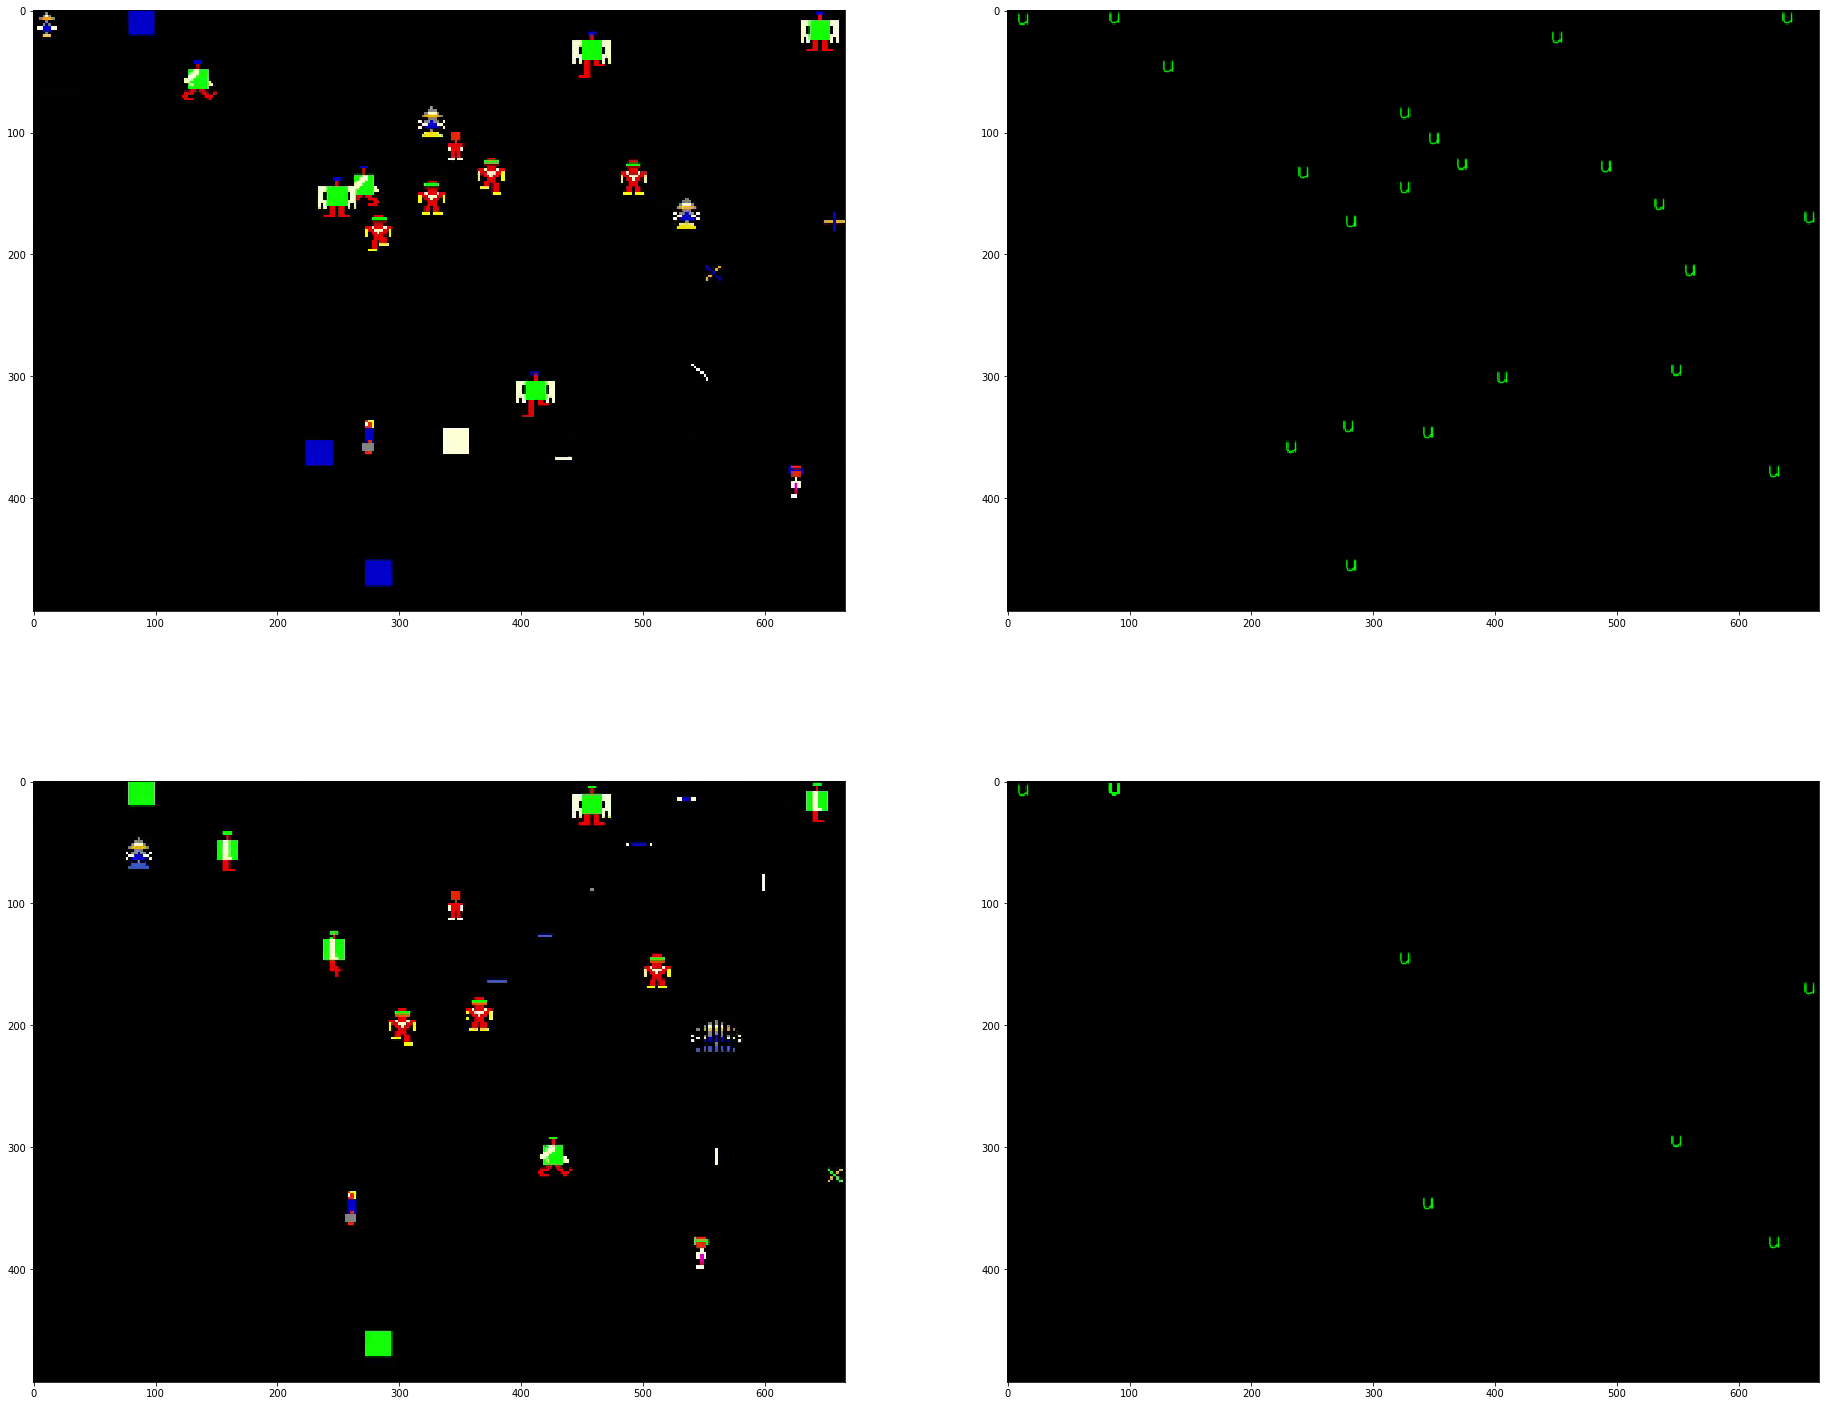

In [24]:
fig = pyplot.figure(figsize=(32, 26))
fig.add_subplot(2, 2, 1)
imshow(crop1)
fig.add_subplot(2, 2, 2)
imshow(rep1)
fig.add_subplot(2, 2, 3)
imshow(crop2)
fig.add_subplot(2, 2, 4)
imshow(rep2)